In [1]:
import os
import random
import math
import networkx as nx
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("training_dataset_Chicago_freeflow.pkl", "rb") as f:
    training_dataset = pickle.load(f)

num_samples = 3000
attack_ratio = 0.4  # 원하는 값으로 조정
bound_threshold = 0.2
random.seed(1234)

In [2]:
# ----------------------------------------
# 1. Hyperparams & Dataset Info
# ----------------------------------------
# 예시 가정: training_dataset = list of dict(...)
#           각 rec: { 'shortest_travel_time':..., 'manipulated_travel_time':..., 'alternative_paths': [ (id, time), ... ] }
# 아래와 같이 필요한 변수도 정의해두세요
num_alts = max(len(rec['alternative_paths']) for rec in training_dataset)
input_dim = 2 + num_alts  # [T_star, T_manip] + num_alts
k = 1 + num_alts          # 출력 차원

# ----------------------------------------
# 2. Model definitions (기존과 동일)
# ----------------------------------------
class Generator(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, k)  # logits (k-dim)

    def forward(self, x):
        # 배치크기가 1일 때 BatchNorm 문제 방지
        if x.size(0) == 1:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
        else:
            h = F.relu(self.bn1(self.fc1(x)))
            h = F.relu(self.bn2(self.fc2(h)))
            h = F.relu(self.bn3(self.fc3(h)))
        return self.fc4(h)

class DiscriminatorTrad(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.size(0) == 1:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
        else:
            h = F.relu(self.bn1(self.fc1(x)))
            h = F.relu(self.bn2(self.fc2(h)))
        return self.fc3(h)

class DiscriminatorBR(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.size(0) == 1:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
        else:
            h = F.relu(self.bn1(self.fc1(x)))
            h = F.relu(self.bn2(self.fc2(h)))
        return self.fc3(h)

# ----------------------------------------
# 3. Instantiate Models & Optimizers
# ----------------------------------------
generator          = Generator(hidden_dim=128)
discriminator_trad = DiscriminatorTrad(hidden_dim=128)
discriminator_br   = DiscriminatorBR(hidden_dim=128)

# Learnable params for WGAN
lambda_delay_param  = nn.Parameter(torch.tensor(0.3))
lambda_reward_param = nn.Parameter(torch.tensor(0.3))
lambda_bound_param  = nn.Parameter(torch.tensor(0.3))
w_delay_param       = nn.Parameter(torch.tensor(-1.0))
w_user_param        = nn.Parameter(torch.tensor(1.0))

init_val = 0.3
lambda_delay_param  = torch.tensor(init_val, requires_grad=False)
lambda_reward_param = torch.tensor(init_val, requires_grad=False)
lambda_bound_param  = torch.tensor(init_val, requires_grad=False)
w_delay_param       = torch.tensor(init_val, requires_grad=False)
w_user_param        = torch.tensor(init_val, requires_grad=False)

#opt_G = optim.Adam(
#    list(generator.parameters()) +
#    [lambda_delay_param, lambda_reward_param, lambda_bound_param, w_delay_param, w_user_param],
#    lr=5e-5, betas=(0.5, 0.9)
#)

opt_G = optim.Adam(
    list(generator.parameters()),
    lr=5e-5, betas=(0.5, 0.9)
)

opt_D_trad = optim.Adam(discriminator_trad.parameters(), lr=5e-5, betas=(0.5, 0.9))
opt_D_br   = optim.Adam(discriminator_br.parameters(),   lr=5e-5, betas=(0.5, 0.9))

# ----------------------------------------
# 4. WGAN Loss functions
# ----------------------------------------
def wgan_critic_loss(real, fake):
    # real -> D(real) 높게, fake -> D(fake) 낮게
    # Loss = -E[D(real)] + E[D(fake)]
    return -real.mean() + fake.mean()

def wgan_generator_loss_dual(
    critic_fake_trad, critic_fake_br,
    gen_input, delta,
    lambda_delay, lambda_reward, lambda_bound,
    candidate_times_batch, tau=1.0
):
    # (1) Adversarial 부분
    loss_adv_trad = -critic_fake_trad.mean()  # Generator는 D(fake)↑ => -D(fake)
    loss_adv_br   = -critic_fake_br.mean()

    # (2) Delay loss
    margin     = gen_input[:,0:1] * attack_ratio
    delay_loss = F.relu((gen_input[:,1:2] + margin) - (gen_input[:,0:1] + delta)).mean()

    # (3) Bound loss
    bound_loss = F.relu(gen_input[:,0:1]*bound_threshold - delta).mean()

    # (4) User surrogate (softmax over R)
    manipulated_time = gen_input[:,0:1] + delta
    R = torch.cat([manipulated_time, candidate_times_batch], dim=1)
    user_probs = F.softmax(-R / tau, dim=1)  # -R => 짧은 시간 경로 선호
    user_loss  = -torch.log(user_probs[:,0] + 1e-8).mean()

    # 동적으로 가중치 적용
#    w_del, w_usr = torch.softmax(torch.stack([w_delay_param, w_user_param]), dim=0)
    w_del, w_usr = torch.softmax(torch.stack([w_delay_param, w_user_param]), dim=0)

    # 최종 Generator loss
    return (loss_adv_trad + loss_adv_br
            + lambda_delay*delay_loss
            - lambda_reward*delta.mean()
            + lambda_bound*bound_loss
            + w_usr*user_loss)

# ----------------------------------------
# 5. Choice Simulation (Critic input)
# ----------------------------------------
def simulate_choice_perfect(rec, manipulated_T):
    times = [manipulated_T] + [t for (_, t) in rec['alternative_paths']]
    return int(torch.argmin(torch.tensor(times)))

def simulate_choice_bounded(rec, manipulated_T, logits, bound_threshold=0.3):
    alt_times = [t for (_, t) in rec['alternative_paths']]
    # bound 범위 안에 하나라도 들어오면 조작경로(0) 선택
    for t in alt_times:
        if abs(t - manipulated_T) <= bound_threshold * manipulated_T:
            return 0
    # 아니면 softmax(logits[1:]) 로 대안 선택
    if len(logits) <= 1:
        return 0
    alt_logits = logits[1:]
    alt_probs  = F.softmax(alt_logits, dim=-1)
    choice_rel = torch.argmax(alt_probs).item()
    return choice_rel + 1

# ----------------------------------------
# 6. Training Loop (모니터링 추가)
# ----------------------------------------
weight_clip = 0.01
patience    = 20
best_loss_G = float('inf')
early_stop  = 0
num_epochs  = 5000
batch_size  = 100

# Critic 모니터링용 리스트
# (epoch별) 전통적 Critic에 대한 D(real), D(fake)
D_trad_real_history = []
D_trad_fake_history = []
# (epoch별) BR Critic에 대한 D(real), D(fake)
D_br_real_history   = []
D_br_fake_history   = []
# (epoch별) Generator Loss
G_loss_history      = []

for epoch in range(1, num_epochs + 1):
    random.shuffle(training_dataset)
    epoch_G   = 0.0
    epoch_Dt  = 0.0
    epoch_Dbr = 0.0

    # 각 배치에서 측정한 D(real), D(fake) 저장할 버퍼
    D_trad_real_vals_batch = []
    D_trad_fake_vals_batch = []
    D_br_real_vals_batch   = []
    D_br_fake_vals_batch   = []

    delta_vals = []

    for i in range(0, len(training_dataset), batch_size):
        batch = training_dataset[i:i+batch_size]
        if not batch:
            break

        # -----------------------------
        # (1) Prepare batch data
        # -----------------------------
        gen_in, cand_times_list, T_alt_eff_list = [], [], []
        for rec in batch:
            T_star  = rec['shortest_travel_time']
            T_manip = rec['manipulated_travel_time']
            alts    = [t for (_, t) in rec['alternative_paths']]

            wts     = [math.exp(-1.0*(t - T_star)) for t in alts]
            wsum    = sum(wts) if sum(wts)!=0 else 1e-8
            T_alt_eff = sum(w*t for w,t in zip(wts, alts)) / wsum

            padded_alts = alts + [1e6]*(num_alts - len(alts))
            gen_in.append([T_star, T_manip] + padded_alts)
            cand_times_list.append(padded_alts)
            T_alt_eff_list.append(T_alt_eff)

        gen_input        = torch.tensor(gen_in, dtype=torch.float32)          # (B, input_dim)
        cand_times_batch = torch.tensor(cand_times_list, dtype=torch.float32) # (B, num_alts)
        T_alt_eff        = torch.tensor(T_alt_eff_list, dtype=torch.float32).unsqueeze(1)

        # -----------------------------
        # (2) Generator forward
        # -----------------------------
        logits = generator(gen_input)             # (B, k)
        probs  = F.softmax(logits, dim=1)         # (B, k)

        path_times      = torch.cat([gen_input[:,1:2], cand_times_batch], dim=1)  # (B, k)
        manipulated_mix = (probs * path_times).sum(dim=1, keepdim=True)           # (B,1)
        delta           = manipulated_mix - gen_input[:,0:1]                      # (B,1)

        # Critic 입력 (Trad)
        diff_real = (T_alt_eff - gen_input[:,0:1]).detach()  # (B,1)
        diff_fake =  T_alt_eff - manipulated_mix             # (B,1)

        # -----------------------------
        # (3) Discriminator (Trad) Update
        # -----------------------------
        real_trad = torch.cat([torch.zeros_like(delta), diff_real], dim=1)  # (B,2)
        fake_trad = torch.cat([delta.detach(), diff_fake.detach()], dim=1)  # (B,2)

        out_r = discriminator_trad(real_trad)  # (B,1)
        out_f = discriminator_trad(fake_trad)  # (B,1)
        loss_Dt_batch = wgan_critic_loss(out_r, out_f)

        opt_D_trad.zero_grad()
        loss_Dt_batch.backward()
        opt_D_trad.step()

        # Weight clipping (WGAN)
        for p in discriminator_trad.parameters():
            p.data.clamp_(-weight_clip, weight_clip)

        # -----------------------------
        # (4) Discriminator (BR) Update
        # -----------------------------
        # real_br_list: bounded-rational에서 0번 경로(조작경로) 선택 -> real
        # fake_br_list: 0번 경로가 아닌 대안을 선택 -> fake
        real_br_list, fake_br_list = [], []
        for idx, rec in enumerate(batch):
            logits_i = logits[idx]
            mT       = manipulated_mix[idx].item()
            choice   = simulate_choice_bounded(rec, mT, logits_i, bound_threshold)
            if choice == 0:
                real_br_list.append(torch.cat([torch.zeros(1), diff_real[idx]]).unsqueeze(0))
            else:
                d_det  = delta[idx].detach()
                df_det = diff_fake[idx].detach()
                fake_br_list.append(torch.cat([d_det, df_det]).unsqueeze(0))

        if real_br_list and fake_br_list:
            real_br = torch.cat(real_br_list, dim=0)  # (R,2)
            fake_br = torch.cat(fake_br_list, dim=0)  # (F,2)
            out_r2  = discriminator_br(real_br)       # (R,1)
            out_f2  = discriminator_br(fake_br)       # (F,1)

            loss_Dbr_batch = wgan_critic_loss(out_r2, out_f2)

            opt_D_br.zero_grad()
            loss_Dbr_batch.backward()
            opt_D_br.step()

            for p in discriminator_br.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        else:
            # real_br_list 혹은 fake_br_list가 비어 있으면
            # D_br 업데이트 불가 → loss_Dbr_batch = 0
            out_r2, out_f2 = None, None
            loss_Dbr_batch = torch.tensor(0.0)

        # -----------------------------
        # (5) Generator Update
        # -----------------------------
        opt_G.zero_grad()
        critic_fake_trad = discriminator_trad(torch.cat([delta, diff_fake], dim=1))
        critic_fake_br   = discriminator_br(torch.cat([delta, diff_fake], dim=1))
        loss_G_batch = wgan_generator_loss_dual(
            critic_fake_trad, critic_fake_br,
            gen_input, delta,
            lambda_delay_param, lambda_reward_param, lambda_bound_param,
            cand_times_batch
        )
        loss_G_batch.backward()
        opt_G.step()

        # -----------------------------
        # (6) Logging (batch-level)
        # -----------------------------
        epoch_Dt  += loss_Dt_batch.item()
        epoch_Dbr += loss_Dbr_batch.item()
        epoch_G   += loss_G_batch.item()

        delta_vals += delta.detach().cpu().tolist()

        # Critic 모니터링 (Trad)
        D_trad_real_vals_batch.append(out_r.mean().item())
        D_trad_fake_vals_batch.append(out_f.mean().item())

        # Critic 모니터링 (BR)
        # real_br, fake_br가 비어있는 배치의 경우 None 처리
        if out_r2 is not None and out_f2 is not None:
            D_br_real_vals_batch.append(out_r2.mean().item())
            D_br_fake_vals_batch.append(out_f2.mean().item())
        else:
            # 데이터가 부족한 경우에는 추가하지 않음 (or 0으로 할 수도 있음)
            pass

    # === End of epoch ===
    n_batches = (len(training_dataset) // batch_size) + 1

    epoch_Dt_mean  = epoch_Dt / n_batches
    epoch_Dbr_mean = epoch_Dbr / n_batches
    epoch_G_mean   = epoch_G / n_batches
    avg_delta      = sum(d[0] for d in delta_vals) / len(delta_vals)

    # (전통적 Critic) WD 추정
    D_trad_real_mean = np.mean(D_trad_real_vals_batch) if len(D_trad_real_vals_batch)>0 else float('nan')
    D_trad_fake_mean = np.mean(D_trad_fake_vals_batch) if len(D_trad_fake_vals_batch)>0 else float('nan')
    WD_est_trad      = D_trad_real_mean - D_trad_fake_mean if not np.isnan(D_trad_real_mean) else float('nan')

    # (BR Critic) WD 추정
    if len(D_br_real_vals_batch) > 0 and len(D_br_fake_vals_batch) > 0:
        D_br_real_mean = np.mean(D_br_real_vals_batch)
        D_br_fake_mean = np.mean(D_br_fake_vals_batch)
        WD_est_br      = D_br_real_mean - D_br_fake_mean
    else:
        D_br_real_mean = float('nan')
        D_br_fake_mean = float('nan')
        WD_est_br      = float('nan')

    # 로그
    print(f"[{epoch}/{num_epochs}] "
          f"D_trad={epoch_Dt_mean:.4f} | D_br={epoch_Dbr_mean:.4f} | G={epoch_G_mean:.4f} "
          f"| Δavg={avg_delta:.4f} | WD_trad≈{WD_est_trad:.4f} | WD_br≈{WD_est_br:.4f}")

    # 히스토리에 기록
    D_trad_real_history.append(D_trad_real_mean if not np.isnan(D_trad_real_mean) else 0.)
    D_trad_fake_history.append(D_trad_fake_mean if not np.isnan(D_trad_fake_mean) else 0.)
    D_br_real_history.append(D_br_real_mean if not np.isnan(D_br_real_mean) else 0.)
    D_br_fake_history.append(D_br_fake_mean if not np.isnan(D_br_fake_mean) else 0.)
    G_loss_history.append(epoch_G_mean)

    # Early Stopping (기존 로직)
    if epoch_G_mean < best_loss_G:
        best_loss_G = epoch_G_mean
        early_stop  = 0
        best_state  = generator.state_dict()
    else:
        early_stop += 1
        if early_stop >= patience:
            print("Early stopping.")
            break

# 최종 Generator 파라미터 로드
generator.load_state_dict(best_state)
print("WGANBR Training complete.")

[1/5000] D_trad=0.0014 | D_br=0.0008 | G=-108306.9695 | Δavg=373084.1649 | WD_trad≈-0.0015 | WD_br≈-0.0008
[2/5000] D_trad=-0.0006 | D_br=-0.0004 | G=-116964.3420 | Δavg=402903.9773 | WD_trad≈0.0006 | WD_br≈0.0004
[3/5000] D_trad=-0.0010 | D_br=-0.0006 | G=-123345.3881 | Δavg=424883.1405 | WD_trad≈0.0010 | WD_br≈0.0007
[4/5000] D_trad=-0.0014 | D_br=-0.0010 | G=-128328.7198 | Δavg=442047.9561 | WD_trad≈0.0015 | WD_br≈0.0010
[5/5000] D_trad=-0.0020 | D_br=-0.0013 | G=-132703.1905 | Δavg=457115.5718 | WD_trad≈0.0020 | WD_br≈0.0013
[6/5000] D_trad=-0.0025 | D_br=-0.0014 | G=-134824.5076 | Δavg=464422.3337 | WD_trad≈0.0025 | WD_br≈0.0014
[7/5000] D_trad=-0.0029 | D_br=-0.0017 | G=-136722.8957 | Δavg=470961.2371 | WD_trad≈0.0030 | WD_br≈0.0018
[8/5000] D_trad=-0.0031 | D_br=-0.0022 | G=-137930.0696 | Δavg=475119.2844 | WD_trad≈0.0032 | WD_br≈0.0023
[9/5000] D_trad=-0.0032 | D_br=-0.0025 | G=-138673.1890 | Δavg=477678.9036 | WD_trad≈0.0033 | WD_br≈0.0026
[10/5000] D_trad=-0.0033 | D_br=-0.00

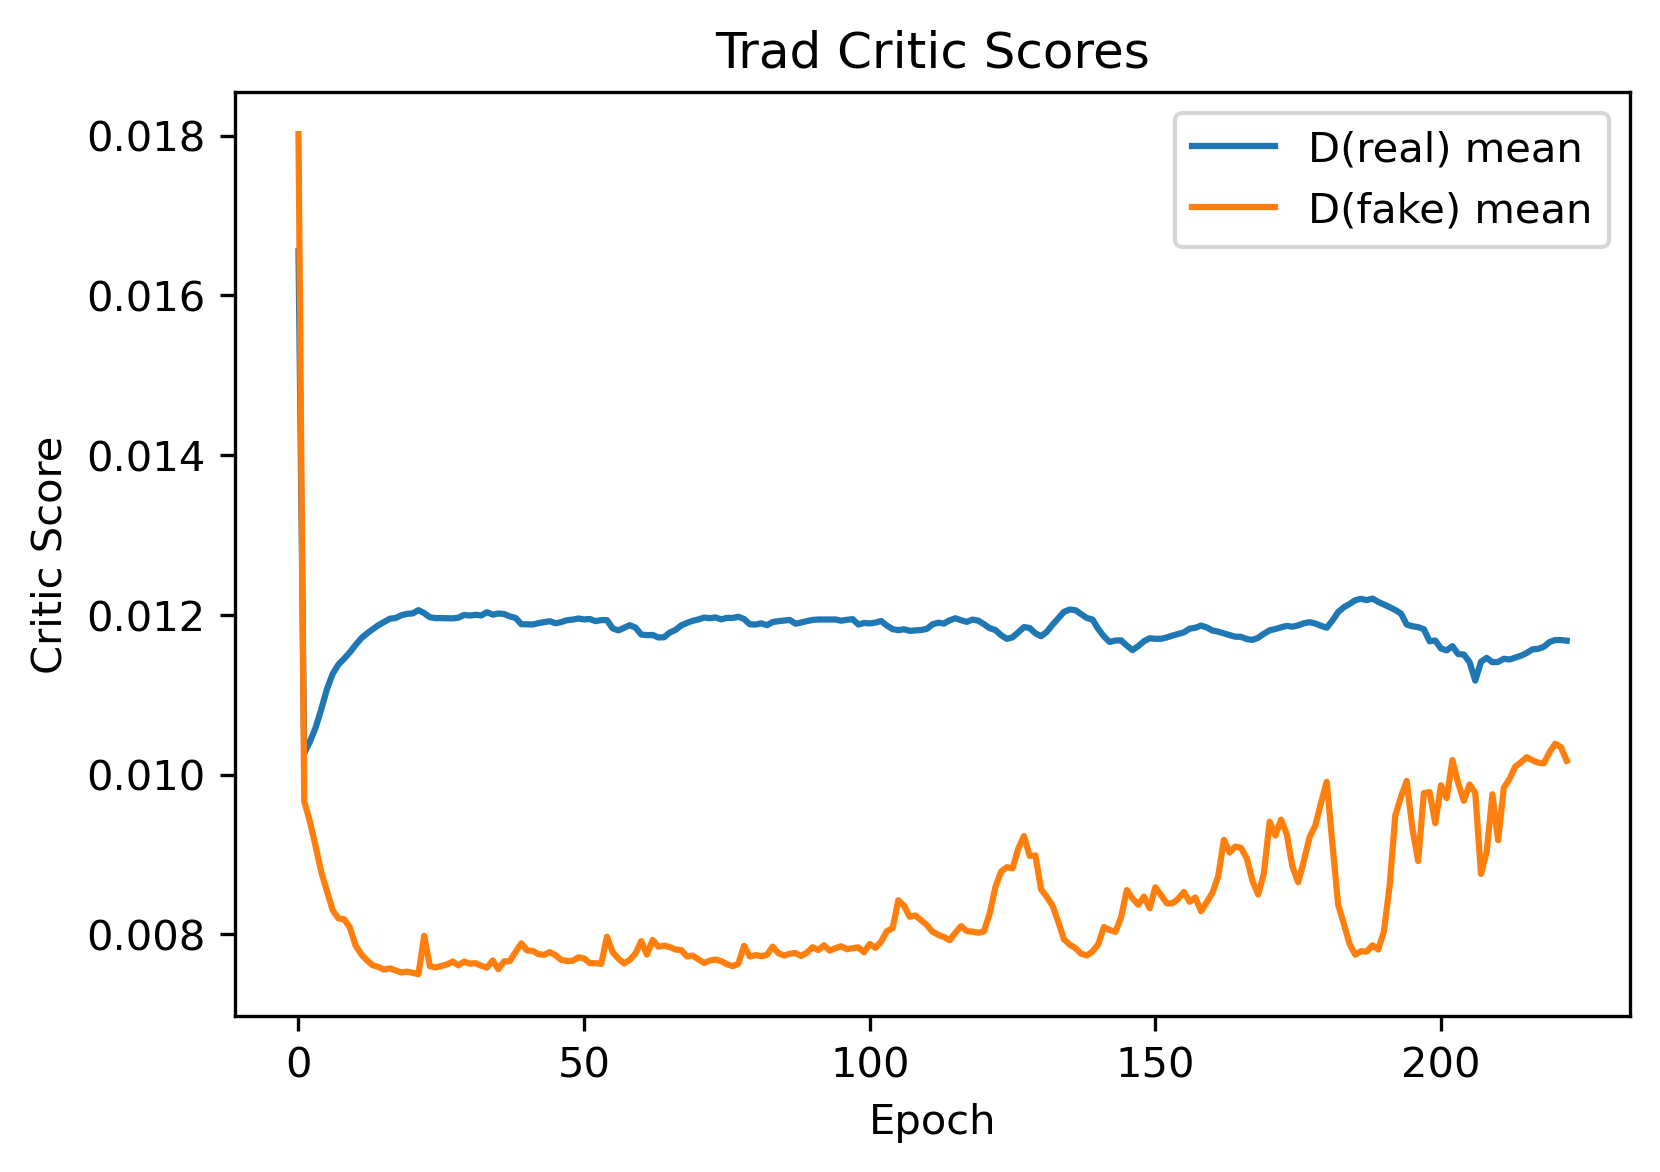

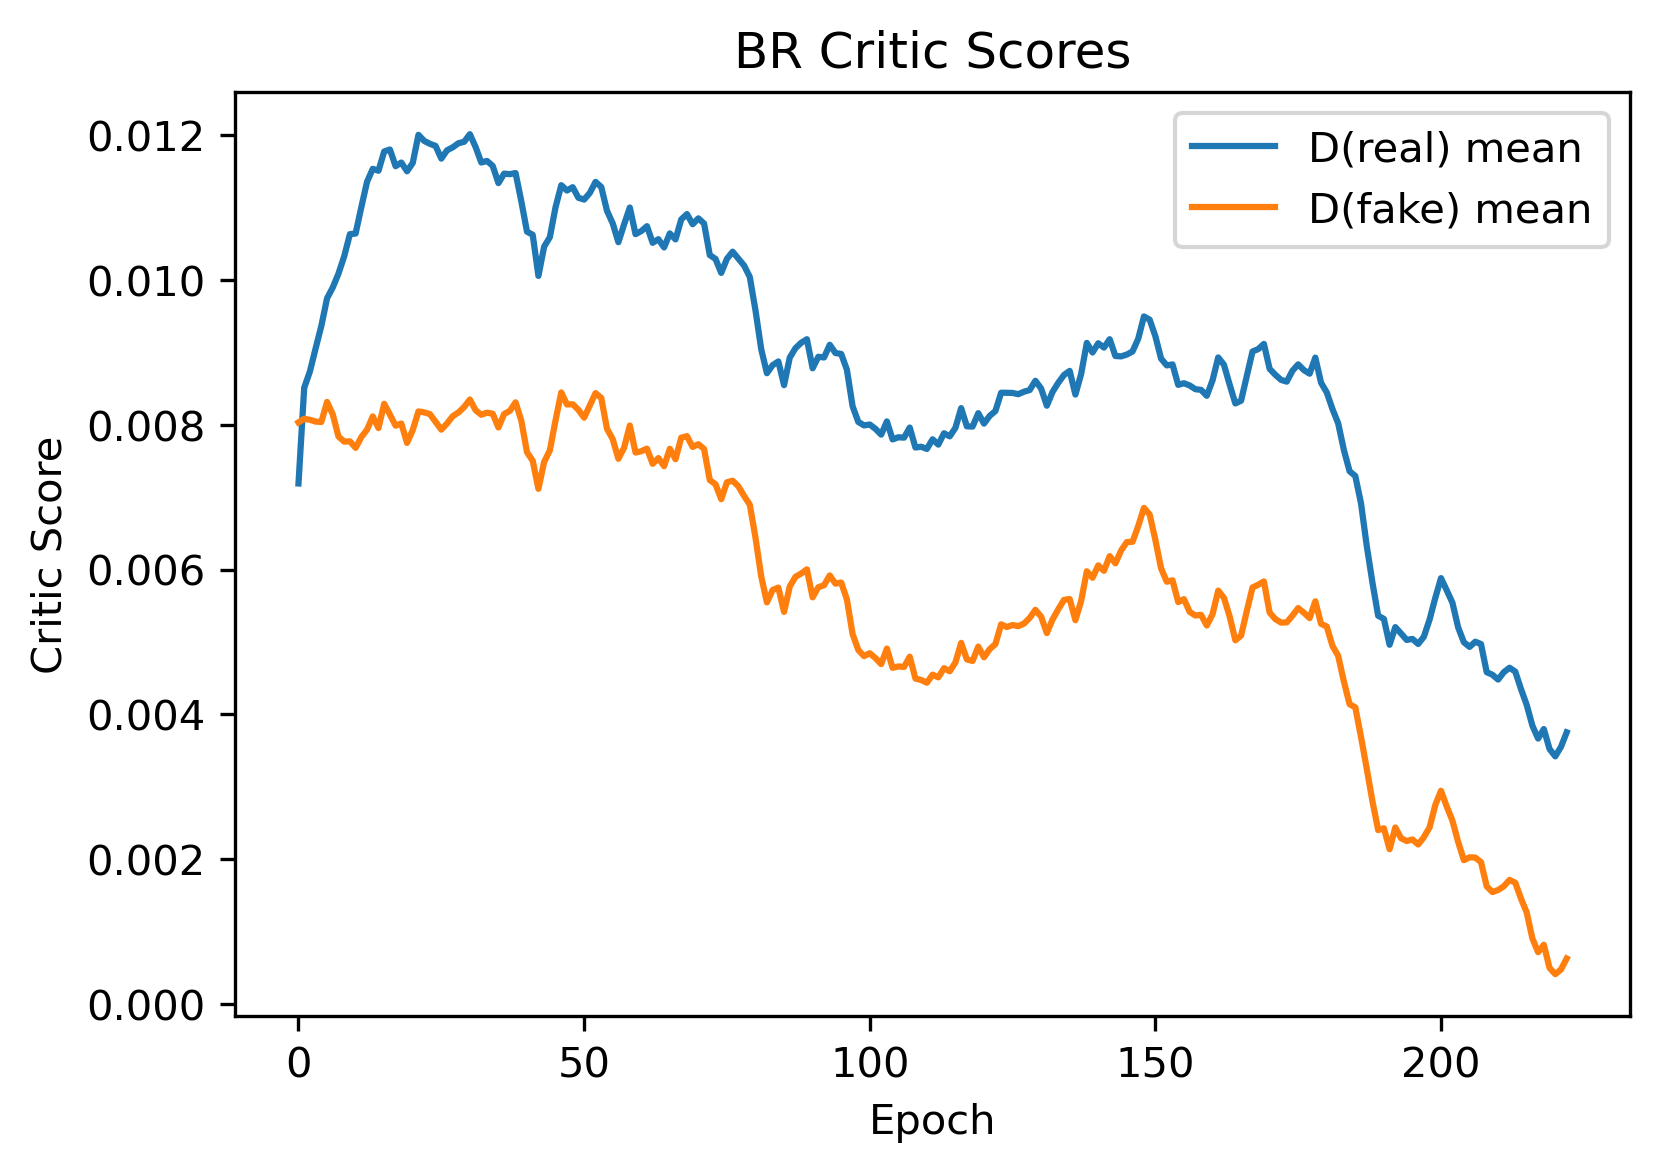

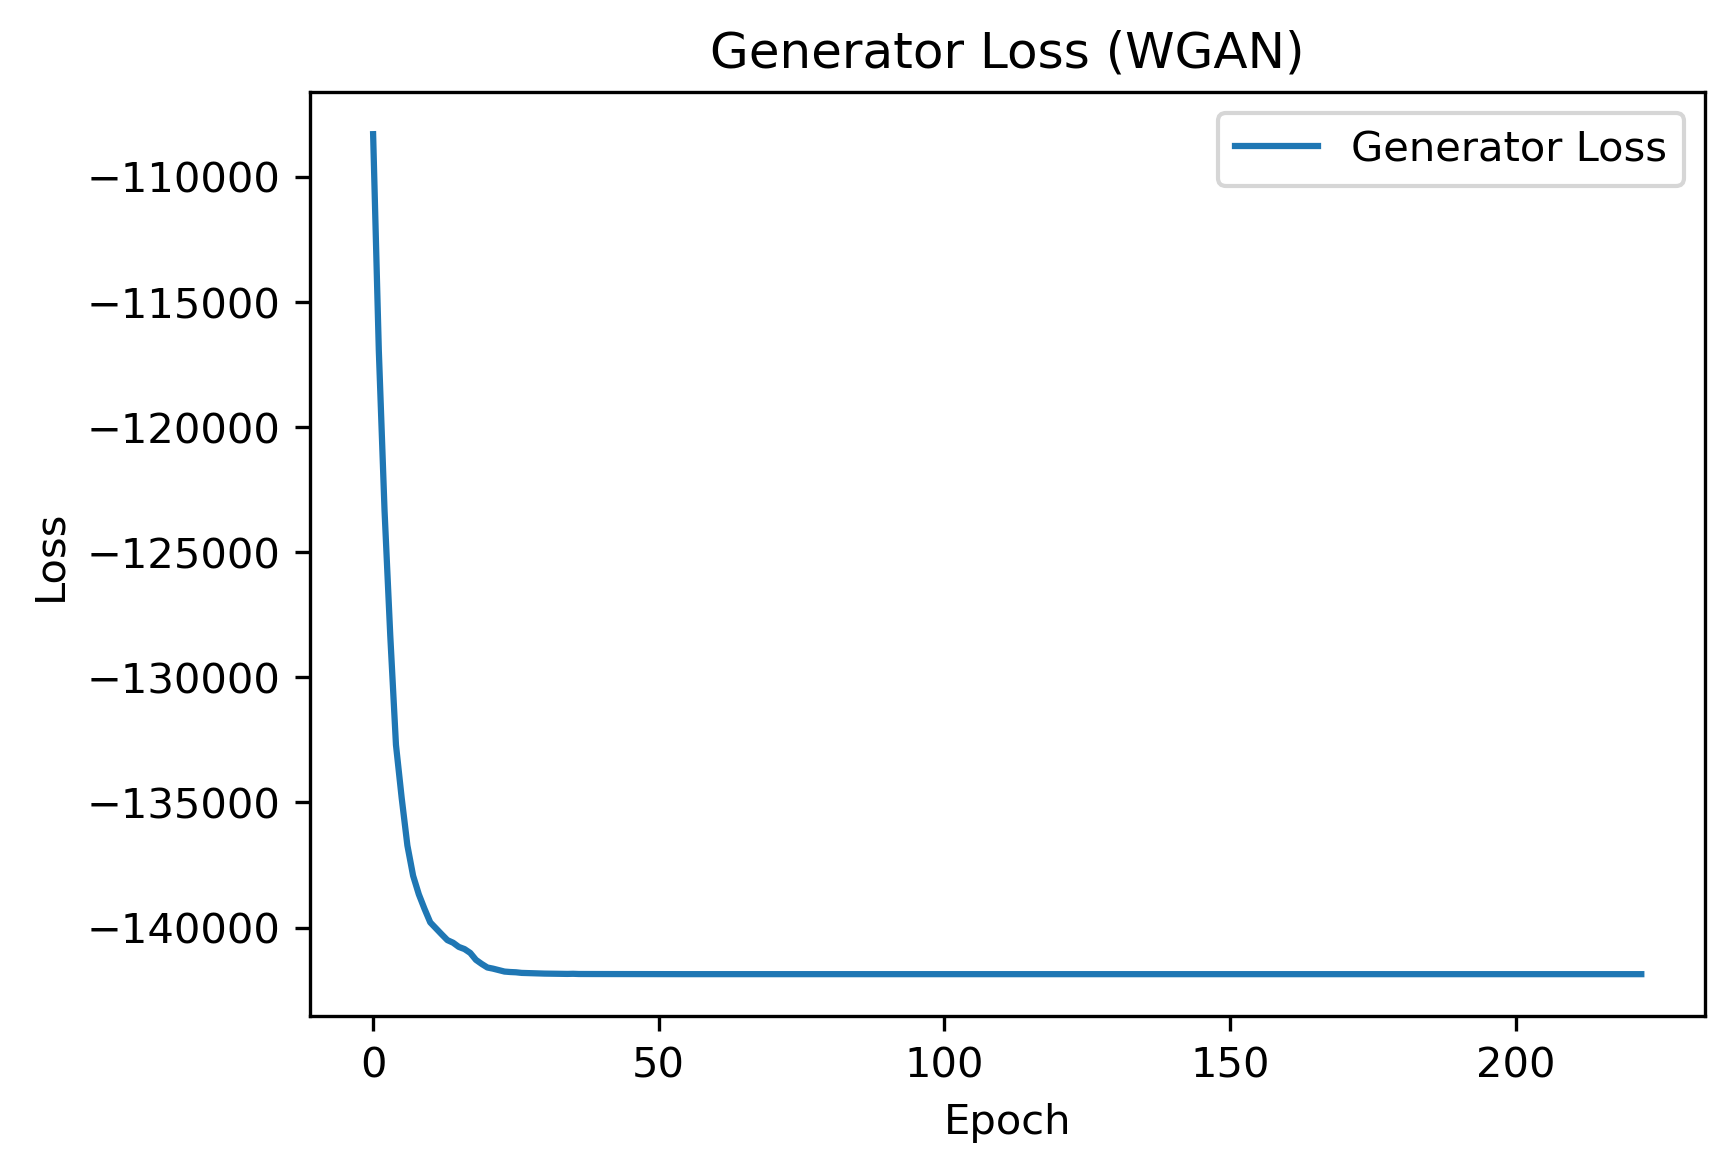

In [3]:
def plot_critic_scores(D_real_hist, D_fake_hist, title="Critic Output", file_name=None):
    plt.figure(figsize=(6,4), dpi=300)  # dpi=300으로 설정
    plt.plot(D_real_hist, label="D(real) mean")
    plt.plot(D_fake_hist, label="D(fake) mean")
    plt.xlabel("Epoch")
    plt.ylabel("Critic Score")
    plt.title(title)
    plt.legend()
    # 파일 이름이 주어지면 저장
    if file_name is not None:
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
    # plt.show()를 쓰면 화면에 표시되며, 필요 없다면 주석 처리 가능
    plt.show()
    plt.close()

def plot_G_loss(G_loss_hist, title="Generator Loss (WGAN)", file_name=None):
    plt.figure(figsize=(6,4), dpi=300)
    plt.plot(G_loss_hist, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if file_name is not None:
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 사용 예시:
plot_critic_scores(D_trad_real_history, D_trad_fake_history,
                   title="Trad Critic Scores",
                   file_name="WGANBR_Chicago_freeflow_trad_critic_scores.png")


plot_critic_scores(D_br_real_history, D_br_fake_history,
                   title="BR Critic Scores",
                   file_name="WGANBR_Chicago_freeflow_critic_scores.png")

plot_G_loss(G_loss_history,
            title="Generator Loss (WGAN)",
            file_name="WGANBR_Chicago_freeflow_generator_loss.png")

In [4]:
num_alts = max(len(rec['alternative_paths']) for rec in training_dataset)

###############################
# 7. 시뮬레이션 함수 수정
#    (조작경로 = 실제 시간도 T_star)
###############################
def simulate_bounded(rec, mT):
    """
    기존 로직 + '조작경로 선택 시 실제 소요시간 = T_star'
    """
    alts = [t for _, t in rec['alternative_paths']]
    for t in alts:
        if abs(t - mT) <= bound_threshold * mT:
            return 0, rec['shortest_travel_time']  # 조작경로 선택 → 실제 T_star
    if not alts:
        # 대안이 전혀 없으면 → 조작경로 선택, 실제 T_star
        return 0, rec['shortest_travel_time']
    # 대안을 선택하면 그 중 최솟값
    rel = int(np.argmin(alts))
    return rel+1, alts[rel]

def simulate_perfect(rec, mT):
    """
    완전 합리적이나, 조작경로 선택 시 실제로도 T_star 소요.
    """
    alt_times = [t for _, t in rec['alternative_paths']]
    # times[0] = 조작경로(안내는 mT, 실제론 T_star)
    # times[1:] = alt_times
    times = [mT] + alt_times
    idx = int(np.argmin(times))

    if idx == 0:
        # 조작경로 선택 → 실제 시간 T_star
        return 0, rec['shortest_travel_time']
    else:
        # 대안 중 하나
        chosen_time = alt_times[idx - 1]
        return idx, chosen_time

################################
# 8. metrics 계산용 함수
################################
def compute_metrics(dataset, manip_list, sim_func):
    chosen_times = []
    delays       = []
    succ         = []
    time_incs    = []

    for rec, mT in zip(dataset, manip_list):
        idx, t_chosen = sim_func(rec, mT)
        T_star = rec['shortest_travel_time']

        chosen_times.append(t_chosen)
        # 기존 최단시간 대비 증가
        delay  = max(0.0, t_chosen - T_star)
        delays.append(delay)

        # 예: idx!=0 이면 "조작경로 아닌 대안 선택"을 success로 볼 수도 있고,
        #     "idx==0이면 조작경로(실제 t_chosen=T_star)"이므로 fail이라 볼 수도 있음.
        succ.append(int(idx != 0))

        # 퍼센트 증가율
        if T_star > 0:
            inc = 100.0 * (t_chosen - T_star) / T_star
        else:
            inc = 0.0
        time_incs.append(inc)

    chosen_arr = np.array(chosen_times)
    delays_arr = np.array(delays)
    succ_arr   = np.array(succ)
    inc_arr    = np.array(time_incs)

    return {
        "Average Time":      chosen_arr.mean(),
        "Time Std":          chosen_arr.std(ddof=0),
        "ADT (min)":     delays_arr.mean(),
        "SDDT (min)":         delays_arr.std(ddof=0),
        "TDT (min)":       delays_arr.sum(),
        "APDT (%)": inc_arr.mean(),
        "SR (%)":  succ_arr.mean()*100
    }

################################
# 9. 예시: Naive / Random / WGAN으로 조작
################################
#  - "조작된 통행시간" 리스트 생성
#  - simulate_* 로 성능평가
################################
generator.eval()

naive_list  = []
random_list = []
gan_list    = []

for rec in training_dataset:
    T_star = rec['shortest_travel_time']
    # (A) Naive: target = T_star*(1+attack_ratio)
    candidates = [T_star] + [t for _, t in rec['alternative_paths']]
    target     = T_star * (1 + attack_ratio)
    diffs      = [abs(c - target) for c in candidates]
    idx_naive  = int(np.argmin(diffs))
    naive_list.append(candidates[idx_naive])

    # (B) Random
    random_list.append(random.choice(candidates))

    # (C) WGAN (GAN) => 혼합된 통행시간
    alts   = [t for _, t in rec['alternative_paths']]
    padded = alts + [1e4]*(num_alts - len(alts))

    inp    = torch.tensor([[T_star, rec['manipulated_travel_time']] + padded],
                          dtype=torch.float32)
    with torch.no_grad():
        logits = generator(inp)  # (1,k)
        probs  = F.softmax(logits, dim=1).numpy()[0]
    path_times = np.array([rec['manipulated_travel_time']] + padded)
    manipulated_mix = (probs * path_times).sum()
    gan_list.append(float(manipulated_mix))

rows = []
for name, lst in [("Naive", naive_list), ("Random", random_list), ("WGAN-BR", gan_list)]:
    # Bounded
    mb = compute_metrics(training_dataset, lst, simulate_bounded)
    mb.update({"Method": name, "Response Model": "Bounded"})
    rows.append(mb)

    # Perfect
    mp = compute_metrics(training_dataset, lst, simulate_perfect)
    mp.update({"Method": name, "Response Model": "Perfect"})
    rows.append(mp)

df = pd.DataFrame(rows)[[
    "Response Model","Method",
    "Average Time","Time Std",
    "ADT (min)","SDDT (min)",
    "TDT (min)","APDT (%)",
    "SR (%)"
]]
print(df.to_string(index=False))

Response Model  Method  Average Time  Time Std  ADT (min)  SDDT (min)  TDT (min)  APDT (%)     SR (%)
       Bounded   Naive     15.918993 11.924150   0.190160    1.081976     570.48  2.949821   3.300000
       Perfect   Naive     16.531640 12.105277   0.802807    0.969732    2408.42  6.121293  79.766667
       Bounded  Random     15.927040 11.907657   0.198207    0.936527     594.62  3.162557   5.566667
       Perfect  Random     16.846600 12.005169   1.117767    1.566600    3353.30  9.646520  81.066667
       Bounded WGAN-BR     16.833823 11.530747   1.104990    1.869591    3314.97 14.053770  48.866667
       Perfect WGAN-BR     17.325250 11.727327   1.596417    1.788592    4789.25 16.843186 100.000000


In [5]:
# 저장 폴더 설정
save_dir = "./Results_Chicago"
os.makedirs(save_dir, exist_ok=True)

# 1) 최적 Generator 파라미터 저장
gen_path = os.path.join(save_dir, "WGANBR_Freeflow_generator_best.pth")
torch.save(generator.state_dict(), gen_path)

# 2) 최적 DiscriminatorTrad 파라미터 저장
disc_trad_path = os.path.join(save_dir, "WGANBR_Freeflow_discriminator_trad_best.pth")
torch.save(discriminator_trad.state_dict(), disc_trad_path)

# 3) 최적 DiscriminatorBR 파라미터 저장
disc_br_path = os.path.join(save_dir, "WGANBR_Freeflow_discriminator_br_best.pth")
torch.save(discriminator_br.state_dict(), disc_br_path)

print(f"Saved generator weights to {gen_path}")
print(f"Saved discriminator_trad weights to {disc_trad_path}")
print(f"Saved discriminator_br weights to {disc_br_path}")

# 4) 학습 로그(history) 저장 (pickle)
history = {
    "D_trad_real_history": D_trad_real_history,
    "D_trad_fake_history": D_trad_fake_history,
    "D_br_real_history": D_br_real_history,
    "D_br_fake_history": D_br_fake_history,
    "G_loss_history": G_loss_history
}
history_path = os.path.join(save_dir, "WGANBR_Freeflow_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Saved training history to {history_path}")

# 5) 결과 DataFrame(df) CSV로 저장
results_path = os.path.join(save_dir, "WGANBR_Freeflow_results_summary.csv")
df.to_csv(results_path, index=False)
print(f"Saved results summary to {results_path}")

Saved generator weights to ./Results_Chicago\WGANBR_Freeflow_generator_best.pth
Saved discriminator_trad weights to ./Results_Chicago\WGANBR_Freeflow_discriminator_trad_best.pth
Saved discriminator_br weights to ./Results_Chicago\WGANBR_Freeflow_discriminator_br_best.pth
Saved training history to ./Results_Chicago\WGANBR_Freeflow_training_history.pkl
Saved results summary to ./Results_Chicago\WGANBR_Freeflow_results_summary.csv
